# Kepler-34 lightcurve preparation for new CB search trials

In [4]:
import numpy as np
import matplotlib.pyplot as p
import kepselfflatten as ksf
from astropy.io import fits

%matplotlib notebook
%load_ext autoreload
%autoreload 2

/Users/davidarmstrong/anaconda/lib/python3.6/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [6]:
#take in lightcurve data

lc = fits.open('K34_jnd.fits')
time = lc[1].data['TIME']
flux = lc[1].data['PDCSAP_FLUX']
sapflux = lc[1].data['SAP_FLUX']
err = lc[1].data['PDCSAP_FLUX_ERR']
nancheck = np.isnan(time) | np.isnan(flux) | np.isnan(err)
time, flux, err, sapflux = time[~nancheck], flux[~nancheck], err[~nancheck], sapflux[~nancheck]
sort = np.argsort(time)
time, flux, err, sapflux = time[sort],flux[sort], err[sort], sapflux[sort]

<IPython.core.display.Javascript object>


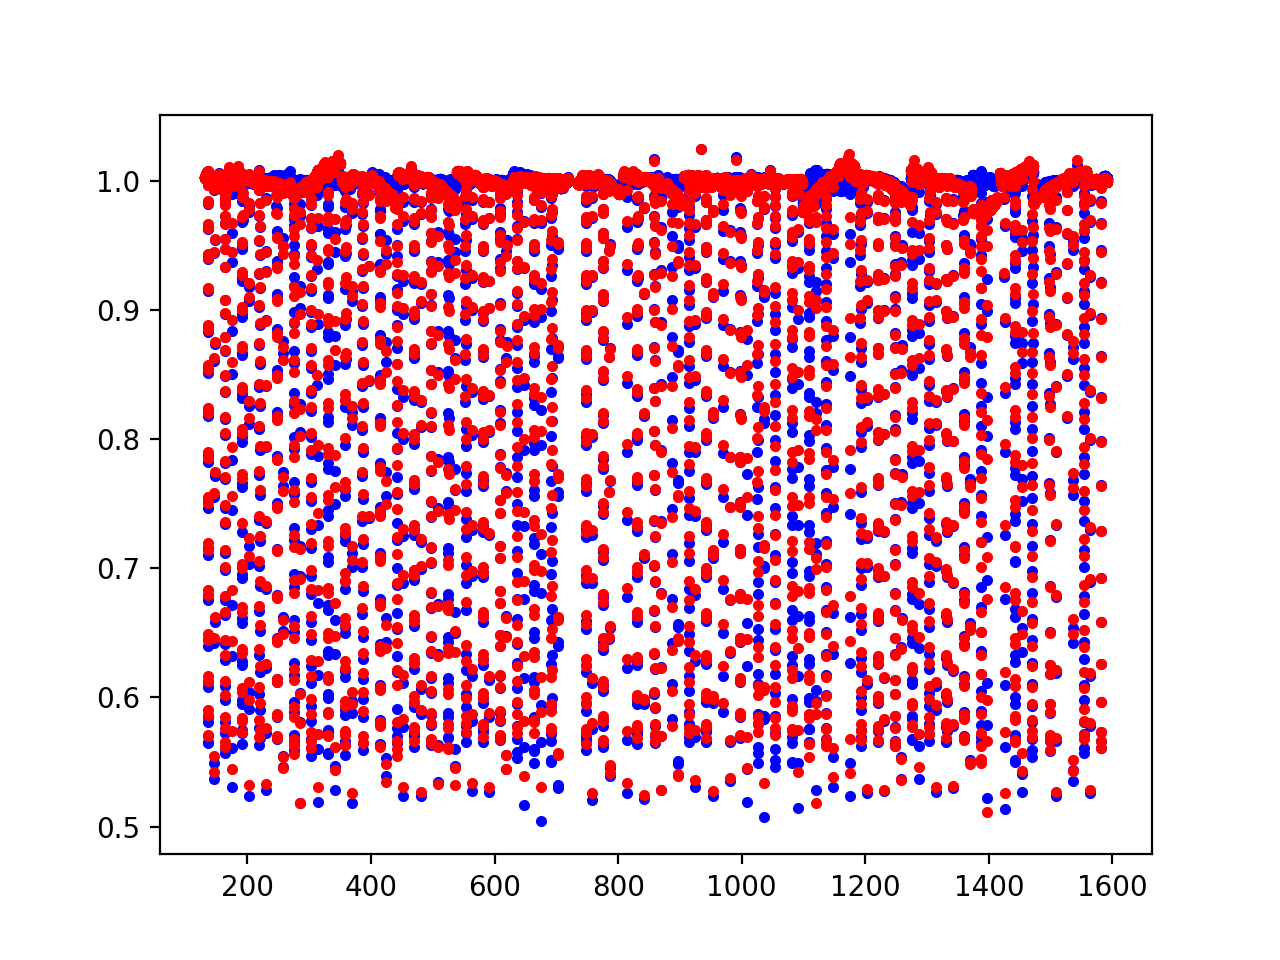

[  131.51194844   131.532383     131.55281747 ...,  1590.96012786
  1590.98056217  1591.00099669]
131.511948435


<IPython.core.display.Javascript object>


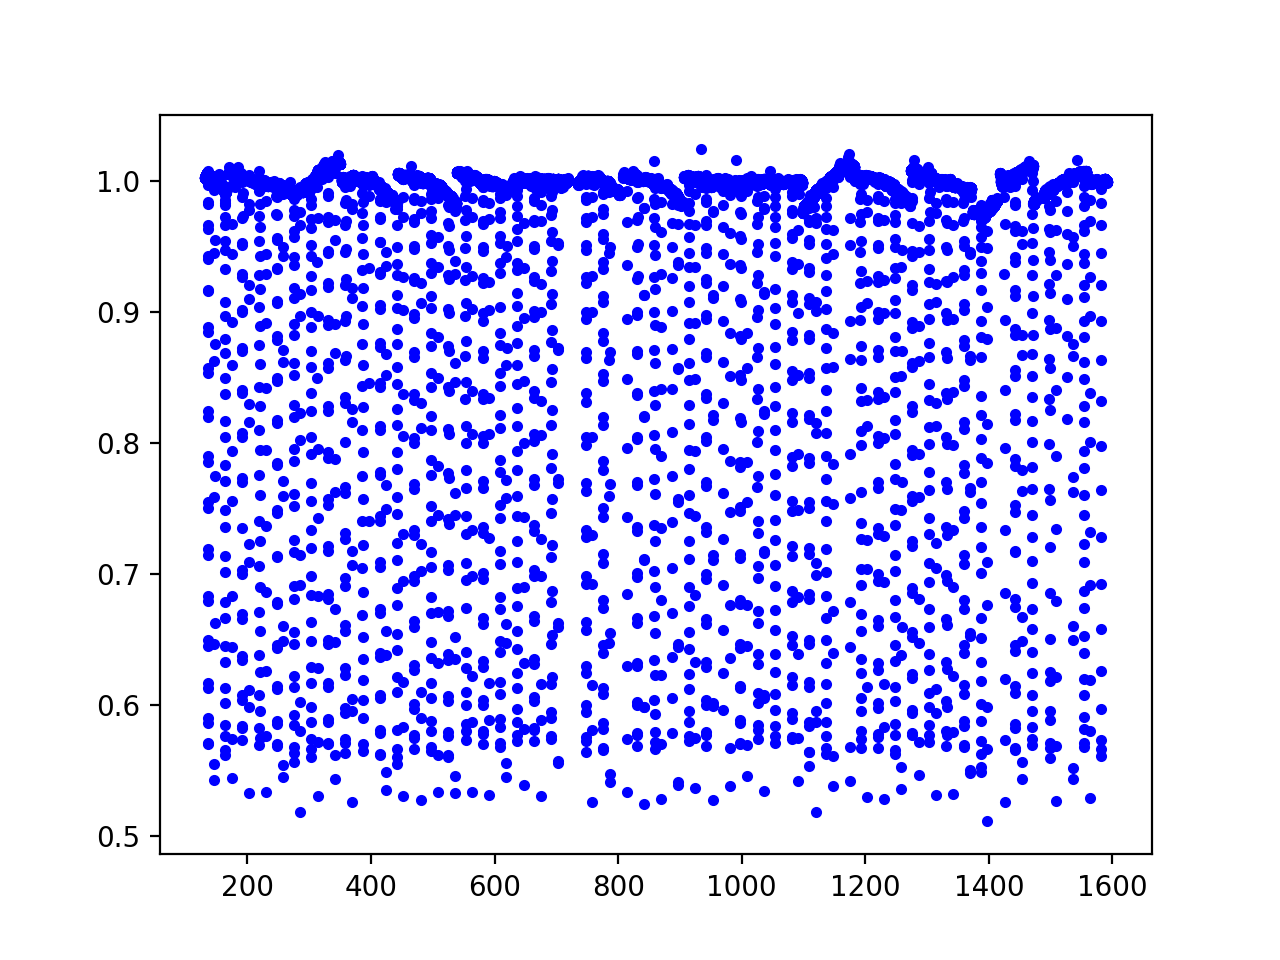

In [7]:
p.figure()
p.plot(time,flux,'b.')
p.plot(time,sapflux,'r.')
#quarter-stitched, but otherwise messy, lightcurve
print(time)
print(np.min(time))
p.figure()
p.plot(time,sapflux,'b.')

In [8]:
#step 1 - remove activity trend and discontinuities
winsize = 3.
stepsize = 0.1
polydegree = 3
niter = 10
sigmaclip = 5
gapthreshold = 0.4
plot = False
transitcut = 2 #number of periodic events to cut
t_per = [27.7958079,27.7958079]  #binary period - will ignore primary eclipses 
                    
t_t0 = [54979.723069 - 54833, 0.6207*t_per[0]+ 54979.723069 - 54833 ]
t_dur = [0.25, 0.75]

lcf =   ksf.Kepflatten(time-time[0],flux,err,np.zeros(len(time)),
                       winsize,stepsize,polydegree,niter,sigmaclip,
                       gapthreshold,time[0],plot,transitcut,
                       t_per,t_t0,t_dur)        


<IPython.core.display.Javascript object>


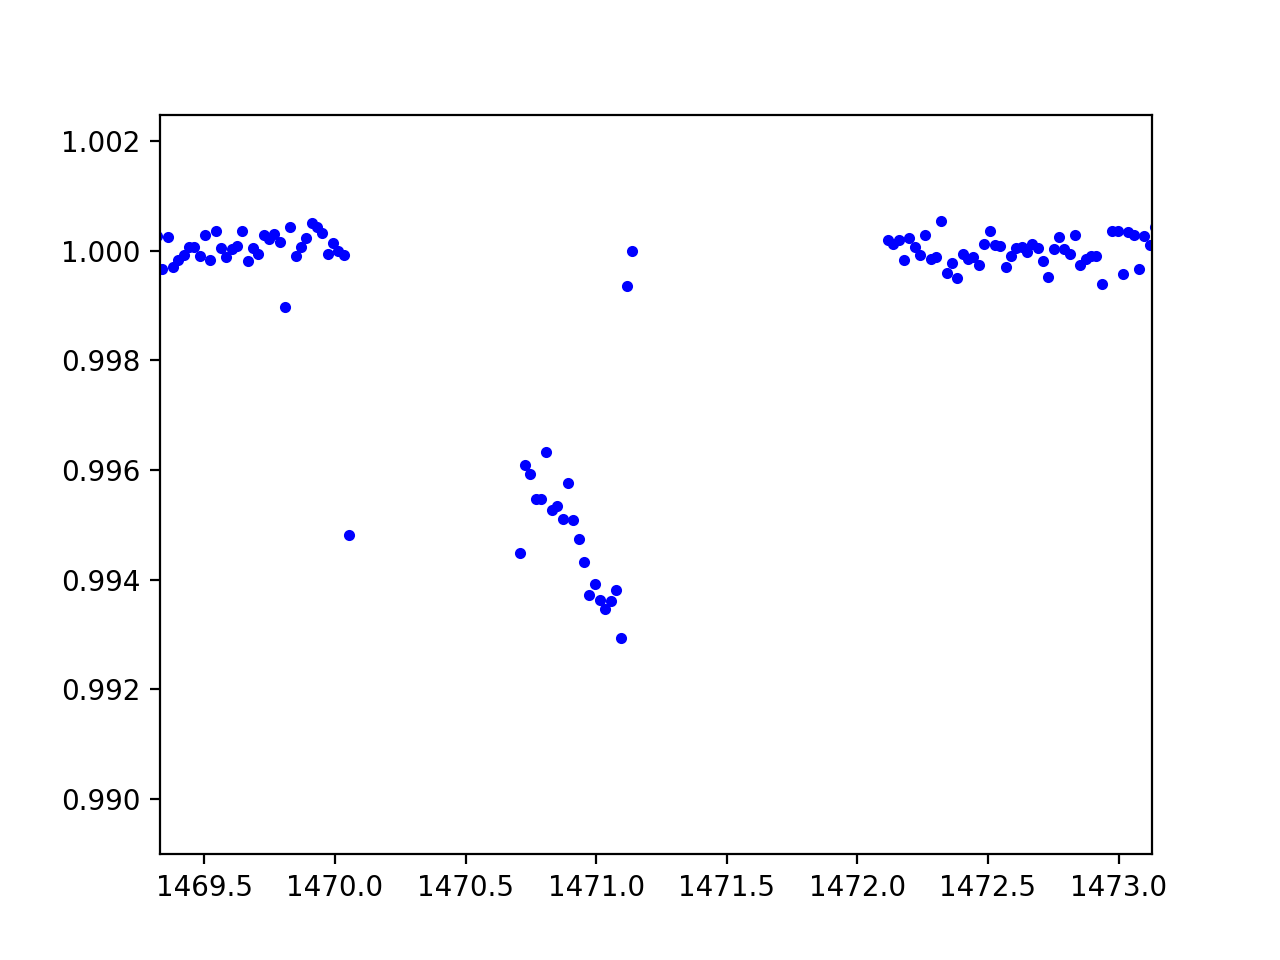

<IPython.core.display.Javascript object>


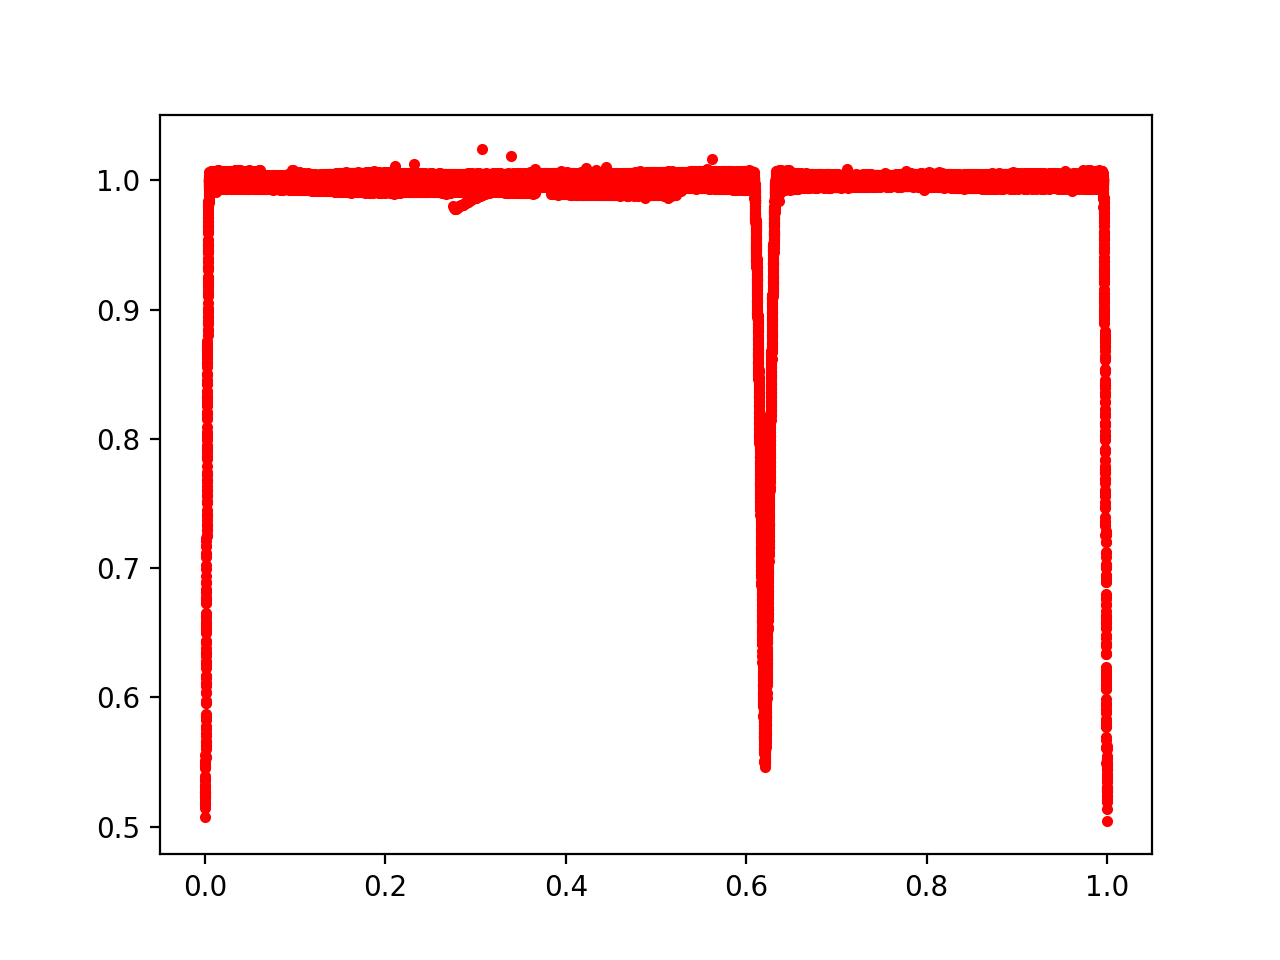

<IPython.core.display.Javascript object>


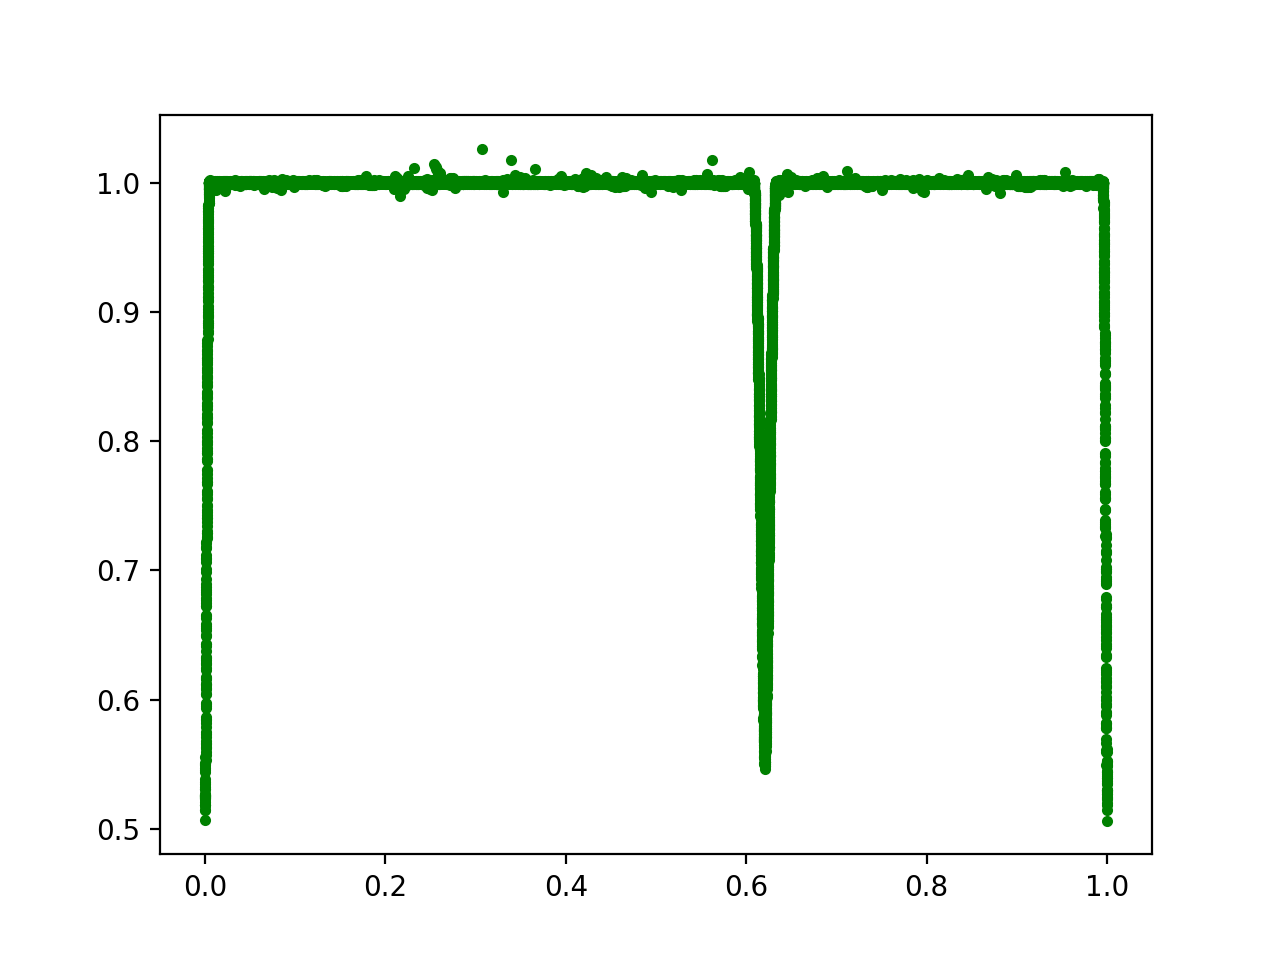

In [9]:
p.figure()
p.plot(lcf[:,0],lcf[:,1],'b.')
phase = np.mod(lcf[:,0]-t_t0[0],t_per[0])/t_per[0]
p.figure()
p.plot(phase,flux,'r.')
p.figure()
p.plot(phase,lcf[:,1],'g.')


<IPython.core.display.Javascript object>


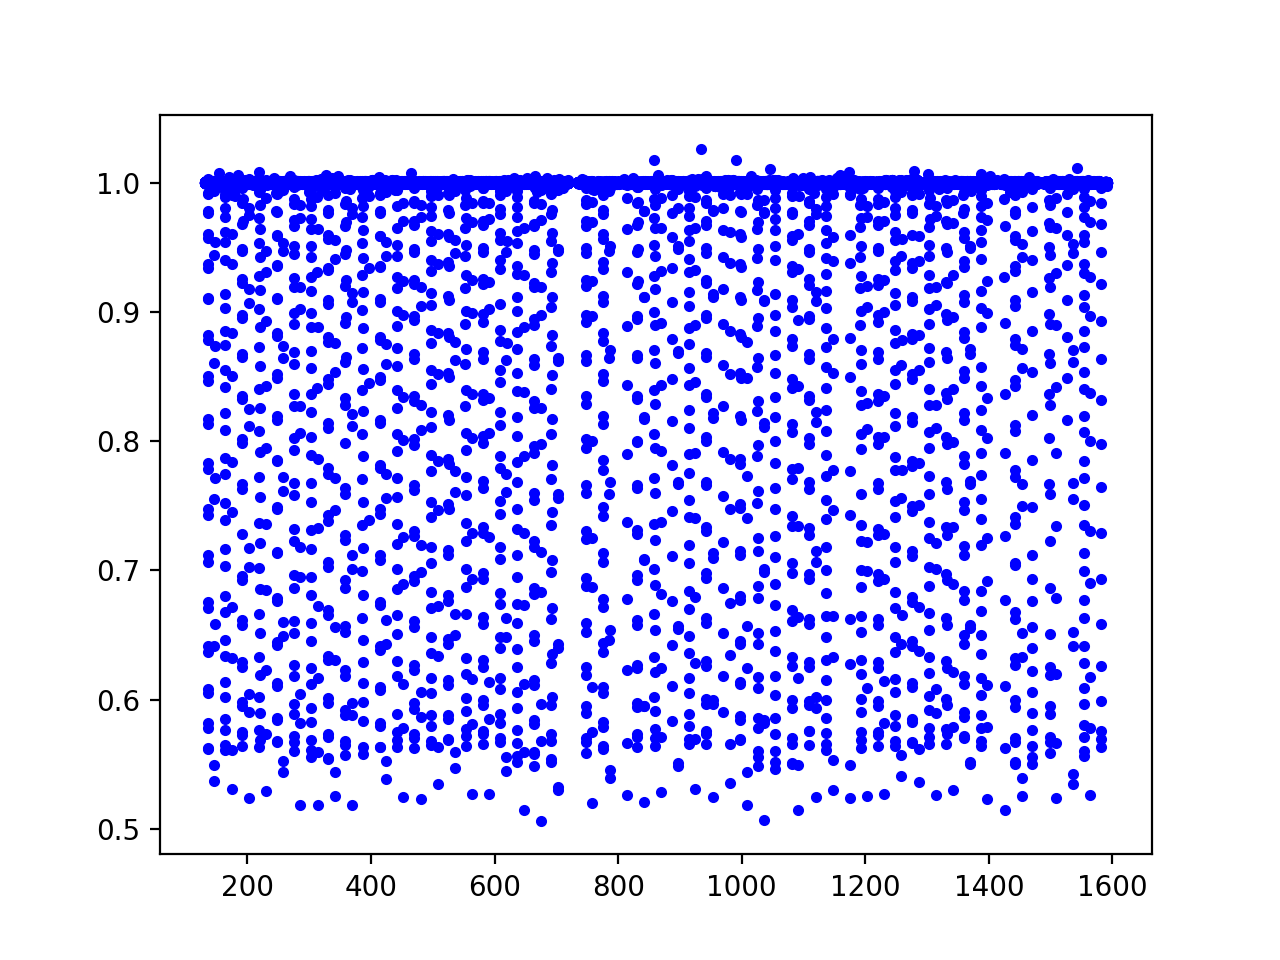

<IPython.core.display.Javascript object>


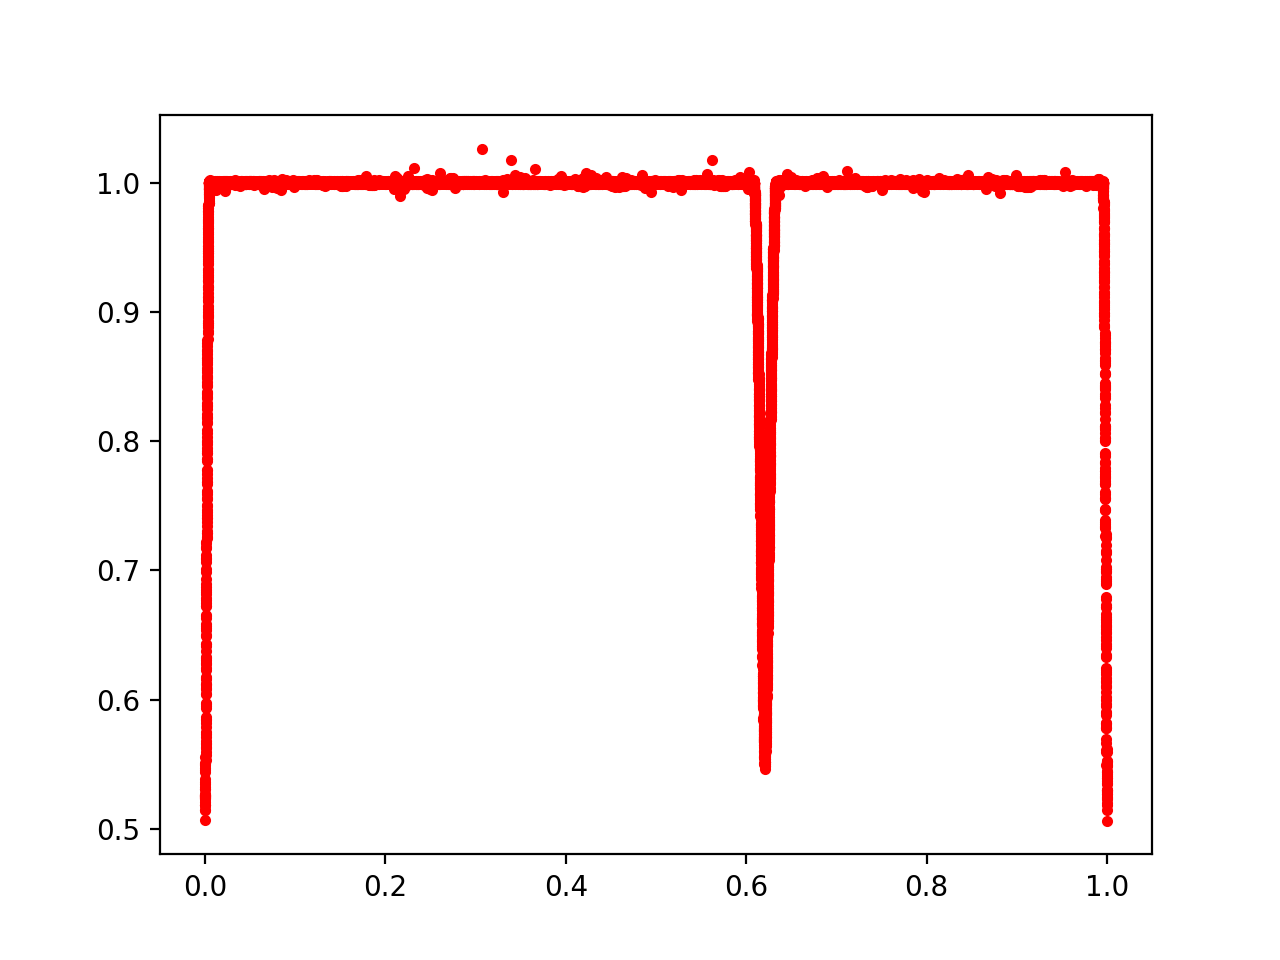

In [10]:
#remove specific time ranges
time, flux, err = lcf[:,0], lcf[:,1], lcf[:,2]

#timecut = np.min(np.where(time>135)) #removes first extra deep binary eclipse
#time, flux, err = time[timecut:], flux[timecut:], err[timecut:]

tmin = 1126.
tmax = 1127.5
cut = (time>tmin) & (time<tmax) & ((flux>1.002) | (flux<0.9988))
time, flux, err = time[~cut], flux[~cut], err[~cut]
tmin = 1470.5
tmax = 1471.5
cut = (time>tmin) & (time<tmax) & ((flux>1.002) | (flux<0.9988))
time, flux, err = time[~cut], flux[~cut], err[~cut]
#tmin = 602.08
#tmax = 603.05
#cut = (time>tmin) & (time<tmax)
#time, flux, err = time[~cut], flux[~cut], err[~cut]

p.figure()
p.plot(time,flux,'b.')


phase = np.mod(time-t_t0[0],t_per[0])/t_per[0]
p.figure()
p.plot(phase,flux,'r.')


<IPython.core.display.Javascript object>


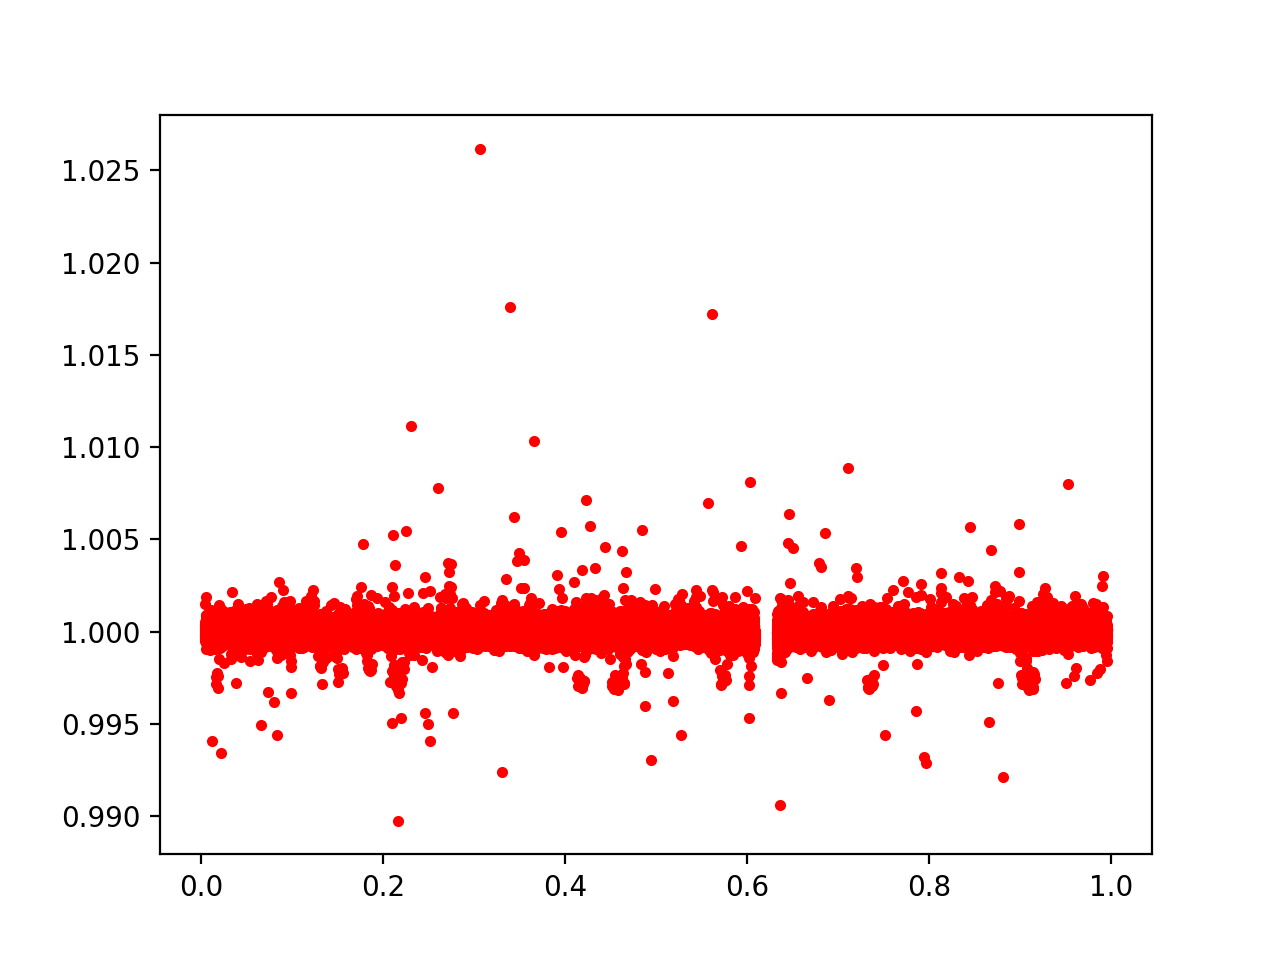

In [11]:
#given the very narrow K16 eclipses, cut them from the lightcurve:

pri_phase = 0.00442 #in phase (half of eclipse, assumes centred at 0)
sec_start = 0.6084
sec_end = 0.6327

cut = (phase<pri_phase) | (phase > (1-pri_phase)) | ( (phase>sec_start) & (phase<sec_end) )
time, flux, err, phase = time[~cut], flux[~cut], err[~cut], phase[~cut]

p.figure()
p.plot(phase,flux,'r.')

In [12]:
#save lightcurve for other search tests

output = np.zeros(len(time))
output = np.array([time,flux,err]).T
np.savetxt('K34_clean_noecl.txt',output)